## Wstępne przetwarzanie danych c.d.

Na danym etapie przeprowadzenie eksploracji danych jest bardzo ciężkim oraz czasochłonnym zadaniem ponieważ zbiór uczący nadal zawiera bardzo dużo kolumn. Więc następnym etapem filtracja cech pod względem właściwości statystycznych.

### Aktualny zakres:
- Transformacja zmiennej celi (do przeniesienia do innego rozdziału)
- Filtracja cech pod względem:
	-  cech stałych
	-  cech quasi-stałych
	-  cech duplikatów
	-  cech o dużej korelacji
- Pierwszy eksperyment uczenia modelu

### Planowane operacje i eksperymenty: 
- Redukcja cech umiejętności (ST, RB, ...) do jednej cechy (np "Skill") za pomocą PCA 
- Przetwarzanie danych odstających
- Normalizacja danych


### Importowanie potrzebnych bibliotek 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split  
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

Po poprzedmin przetwarzaniu danych nasz zbiór znajduje się już w nowym pliku

In [2]:
fifa_data = pd.read_csv('new_data.csv')

In [3]:
cols =  ['Preferred Foot', 'Body Type' , 'Work Rate', 'Position']
for col in cols:
    fifa_data[col] = fifa_data[col].astype('category')

In [4]:
fifa_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16122 entries, 0 to 16121
Data columns (total 66 columns):
Age                16122 non-null int64
Overall            16122 non-null int64
Potential          16122 non-null int64
Preferred Foot     16122 non-null category
Weak Foot          16122 non-null float64
Skill Moves        16122 non-null float64
Work Rate          16122 non-null category
Body Type          16122 non-null category
Position           16122 non-null category
Height             16122 non-null float64
Weight             16122 non-null float64
LS                 16122 non-null int64
ST                 16122 non-null int64
RS                 16122 non-null int64
LW                 16122 non-null int64
LF                 16122 non-null int64
CF                 16122 non-null int64
RF                 16122 non-null int64
RW                 16122 non-null int64
LAM                16122 non-null int64
CAM                16122 non-null int64
RAM                16122 non-nu

In [5]:
fifa_no_category = fifa_data.select_dtypes(exclude=['category'])

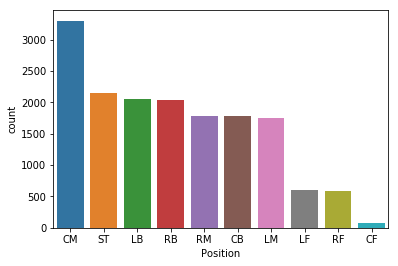

In [6]:
position = fifa_data['Position']
sns.countplot(position, order=position.value_counts().index)

In [7]:
print('CF count', len(position[position == 'CF']))

CF count 74


In [8]:
print('CM count', len(position[position == 'CM']))

CM count 3300


In [9]:
print('data records number =', len(position))

data records number = 16122


In [10]:
fifa_data['Position'] = fifa_data['Position'].apply(lambda x: x if x not in ['LF','CF','RF'] else 'F')

In [11]:
target = fifa_data['Position']
fifa_data.drop('Position', axis=1, inplace=True)

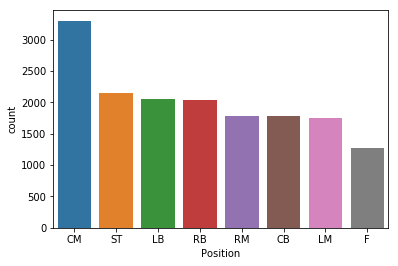

In [12]:
sns.countplot(target, order=target.value_counts().index)

### Usuwanie cech stałych

In [13]:
constant_filter = VarianceThreshold(threshold=0)

In [14]:
constant_filter.fit(fifa_no_category)

VarianceThreshold(threshold=0)

In [15]:
selected_features =  fifa_no_category.columns[constant_filter.get_support()]
constant_features = [feature for feature in fifa_no_category if feature not in selected_features]
constant_features

[]

Oryginalny zbiór uczący nie zawiera cech stałych

### Usuwanie quasi-stałych cech

In [16]:
VARIANCE_THRESHHOLD = 0.2
qconstant_filter = VarianceThreshold(threshold=VARIANCE_THRESHHOLD)
qconstant_filter.fit(fifa_no_category)
selected_features =  fifa_no_category.columns[qconstant_filter.get_support()]
qconstant_features = [feature for feature in fifa_no_category if feature not in selected_features]
qconstant_features

[]

Oryginalny zbiór uczący nie zawiera cech stałych

### Usuwanie Cech duplikatów

In [17]:
fifa_data.shape

(16122, 65)

In [18]:
fifa_T = fifa_data.T

In [19]:
fifa_T.shape

(65, 16122)

In [20]:
fifa_T_no_duplictes = fifa_T.drop_duplicates(keep='first')

In [21]:
fifa_T_no_duplictes.shape

(49, 16122)

In [22]:
fifa_no_duplictes_features = fifa_T_no_duplictes.T

In [23]:
fifa_no_duplictes_features.columns

Index(['Age', 'Overall', 'Potential', 'Preferred Foot', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Height', 'Weight', 'LS', 'LW',
       'LF', 'LAM', 'LM', 'LCM', 'LWB', 'LDM', 'LB', 'LCB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle'],
      dtype='object')

In [24]:
duplictes_features = [feature for feature in fifa_data.columns if feature not in 
                                                                  fifa_no_duplictes_features.columns ] 
duplictes_features

['ST',
 'RS',
 'CF',
 'RF',
 'RW',
 'CAM',
 'RAM',
 'CM',
 'RCM',
 'RM',
 'CDM',
 'RDM',
 'RWB',
 'CB',
 'RCB',
 'RB']

Widzimy że mamy cechy, które tylko powtażają pewną informacje, któtch nie potrzebujemy mieć w zbiorze uczącym 

In [25]:
fifa_data.drop(columns=duplictes_features, axis=1, inplace=True)

In [26]:
fifa_data.shape

(16122, 49)

### Usuwanie cech o dużej korelacji (przeniesione do EDA)

## Eksperyment uczenia modelu

In [27]:
label_encoder = LabelEncoder()

In [28]:
fifa_categories = fifa_data.select_dtypes('category')

In [29]:
def encode_labels(col):
    return label_encoder.fit_transform(col)

In [30]:
fifa_data[fifa_categories.columns] = fifa_data[fifa_categories.columns].apply(encode_labels)

In [31]:
 X_train, X_test, y_train, y_test = train_test_split(
        fifa_data, target, test_size=0.33, random_state=42)

In [32]:
decision_tree_model = DecisionTreeClassifier()

In [33]:
fifa_data.head()

,Age,Overall,Potential,Preferred Foot,Weak Foot,Skill Moves,Work Rate,Body Type,Height,Weight,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,31,94,94,0,4.0,4.0,8,1,170.18,72.11,...,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0
1,33,94,94,1,4.0,5.0,1,1,187.96,82.99,...,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0
2,26,92,93,1,5.0,5.0,2,1,175.26,68.03,...,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0
3,27,91,92,1,5.0,4.0,0,1,180.34,69.84,...,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0
4,27,91,91,1,4.0,4.0,2,1,172.72,73.92,...,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0


In [34]:
decision_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [35]:
pred = decision_tree_model.predict(X_test)

In [36]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          CB       0.53      0.52      0.52       581
          CM       0.52      0.49      0.51      1138
           F       0.20      0.21      0.21       409
          LB       0.56      0.60      0.58       659
          LM       0.19      0.21      0.20       546
          RB       0.52      0.52      0.52       677
          RM       0.23      0.23      0.23       608
          ST       0.71      0.67      0.69       703

   micro avg       0.45      0.45      0.45      5321
   macro avg       0.43      0.43      0.43      5321
weighted avg       0.46      0.45      0.46      5321



Na razie model radzi sobie bardzo słabo, co jest dość oczekiwanyn wynikiem. Ale możemy sprawdzić czy da się ten wynik poprawić za pomocą np użyciu bagginge, czyli w tym przypadku algorytm **Lasów Losowych** 

In [37]:
forest = RandomForestClassifier(n_estimators=100)

In [38]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [39]:
forest_pred = forest.predict(X_test)

In [40]:
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

          CB       0.57      0.75      0.65       581
          CM       0.58      0.82      0.68      1138
           F       0.38      0.28      0.32       409
          LB       0.75      0.64      0.69       659
          LM       0.30      0.18      0.23       546
          RB       0.69      0.68      0.68       677
          RM       0.33      0.13      0.19       608
          ST       0.72      0.89      0.79       703

   micro avg       0.59      0.59      0.59      5321
   macro avg       0.54      0.55      0.53      5321
weighted avg       0.56      0.59      0.56      5321

